# Customer Lifetime Value Prediction 

In [ ]:
git clone https://github.com/saigurram/Marketing_CLTV.git

## Define 

Predicting the revenue and customer lifetime value is crucial for any organization not only from Sales Perspective 
but also for supply chain and marketing. Marketing can use these values to optimize the ad spend and supply chain for anticipating future demand. 

Brazillian ecommerce dataset consists of ecommerce data at product/seller level along with few marketing metrics. 
After careful analysis, the marketing metrics had a lot of missing data and therefore haven't been used in this analysis. 
The customer and seller information consists various states/cities. For easier analysis, the metrics haven't been used. 

Objective:
    
Understand how new vs existing customers are growing and what are their revenue contributions. 
Predict the Revenue at transaction level and combine it with their customers. 



In [109]:
# Import Libraries
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from kmodes import kmodes
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

__author__ = "Sai Jyothi Gurram"
__email__ = "jyothisai1993@gmail.com"

# DISCOVER

### ----2  Load the data ----

In [2]:
product = pd.read_csv('olist_products_dataset.csv')

In [3]:
product_translation = pd.read_csv('product_category_name_translation.csv')

In [4]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [5]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv')

In [6]:
customer = pd.read_csv('olist_customers_dataset.csv')

In [7]:
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [8]:
#merge product with product category translation 
product = product[['product_id','product_category_name']]
product_cat = product.merge(product_translation,on ='product_category_name',how = 'left')
product_cat.drop(['product_category_name'],axis = 1, inplace = True)

In [9]:
#checking the shape of combined dataframe
product_cat.shape

(32951, 2)

In [10]:
#merging order_items with product_cat 
closed_order_items = order_items.merge(product_cat,on ='product_id',how = 'left')

In [11]:
#checking the shape of combined dataframe
closed_order_items.shape

(112650, 8)

In [12]:
#orders
orders = orders[['order_id','customer_id','order_purchase_timestamp']]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

In [13]:
#customer
customer = customer[['customer_id', 'customer_unique_id']]
customer = customer.set_index('customer_id')

In [14]:
#combining customer with orders 
order_customer = pd.concat([orders,customer], axis=1, join='inner')
order_customer.reset_index(inplace=True)

In [15]:
#checking the shape of combined dataframe
order_customer.shape

(99441, 4)

In [16]:
#merging closed_order_items with orders
merged = closed_order_items.merge(order_customer,on ='order_id',how = 'left')

In [17]:
#checking the shape of combined dataframe
merged.shape

(112650, 11)

### ----3  Clean the data ----

In [18]:
#converting all dates into datetimes


merged['shipping_limit_date'] = pd.to_datetime(merged['shipping_limit_date'])
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])



In [19]:
#As our target column is revenue checking for duplicates 
print("Number of duplicated records in training set: ", merged.duplicated().sum())

Number of duplicated records in training set:  0


In [20]:
#checking the datatypes 
merged.dtypes

order_id                                 object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
product_category_name_english            object
customer_id                              object
order_purchase_timestamp         datetime64[ns]
customer_unique_id                       object
dtype: object

In [21]:
#checking for null values
merged.isnull().any()

order_id                         False
order_item_id                    False
product_id                       False
seller_id                        False
shipping_limit_date              False
price                            False
freight_value                    False
product_category_name_english     True
customer_id                      False
order_purchase_timestamp         False
customer_unique_id               False
dtype: bool

In [22]:
#checking the count of null values
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 11 columns):
order_id                         112650 non-null object
order_item_id                    112650 non-null int64
product_id                       112650 non-null object
seller_id                        112650 non-null object
shipping_limit_date              112650 non-null datetime64[ns]
price                            112650 non-null float64
freight_value                    112650 non-null float64
product_category_name_english    111023 non-null object
customer_id                      112650 non-null object
order_purchase_timestamp         112650 non-null datetime64[ns]
customer_unique_id               112650 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 10.3+ MB


In [23]:
#replacing null values with other
merged['product_category_name_english'] = merged['product_category_name_english'].fillna('Other') 



In [24]:
#dropping unnecessary columns
merged.drop(['seller_id','shipping_limit_date','product_id'],axis = 1, inplace = True)

In [25]:
#creating the target revenue column 
merged['Revenue'] = merged['price']+merged['freight_value']

In [26]:
#dropping columns
merged.drop(['price','freight_value'],axis = 1, inplace = True)

### ----4 Explore the data ----

In [27]:
#EDA 
#the number of orders in the datset

merged.shape

#there are 112650 orders

(112650, 7)

In [28]:
#total Revenue 
print ("total Revenue = %2.2f" % merged['Revenue'].sum())

total Revenue = 15843553.24


In [29]:
#analyzing order_purchase date
merged['order_purchase_timestamp'].describe()


count                  112650
unique                  98112
top       2017-07-16 18:19:25
freq                       21
first     2016-09-04 21:15:19
last      2018-09-03 09:06:57
Name: order_purchase_timestamp, dtype: object

data here is for two years from September 2016 until September 2018

In [30]:
#Creating a new column month to simplify the analysis
merged['Month'] = merged['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [31]:
#Excluding 2016 September and 2018 September as data is incomplete
merged = merged[merged['Month'] > 201609]
merged = merged[merged['Month'] < 201809]

In [32]:
merged.shape

(112643, 8)

In [35]:
#analyzing revenue 
merged['Revenue'].describe()

count    112643.000000
mean        140.648172
std         190.729357
min           6.080000
25%          55.225000
50%          92.320000
75%         157.940000
max        6929.310000
Name: Revenue, dtype: float64

Average revenue is 140 while the standard deviation is 190. 

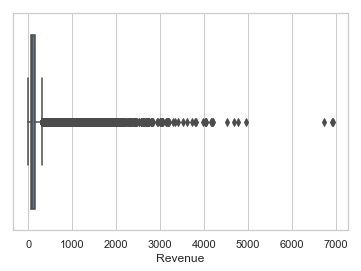

In [38]:
#Creating a boxplot for revenue 
sns.boxplot(x=merged["Revenue"])

In [39]:
#checking the IQR
Q1 = merged['Revenue'].quantile(0.25)
Q3 = merged['Revenue'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

102.715


In [40]:
#checking the data within 1.5*times IQR
print("Less than 1.5 IQR",merged[merged['Revenue'] < (Q1 - 1.5 * IQR)])
print("Greater than 1.5 IQR",merged[merged['Revenue'] > (Q1 + 1.5 * IQR)])

Less than 1.5 IQR Empty DataFrame
Columns: [order_id, order_item_id, product_category_name_english, customer_id, order_purchase_timestamp, customer_unique_id, Revenue, Month]
Index: []
Greater than 1.5 IQR                                 order_id  order_item_id  \
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
7       000576fe39319847cbb9d288c5617fa6              1   
16      0009c9a17f916a706d71784483a5d643              1   
25      00119ff934e539cf26f92b9ef0cdfed8              1   
26      0011d82c4b53e22e84023405fb467e57              1   
30      00137e170939bba5a3134e2386413108              1   
39      0017afd5076e074a48f1f1a4c7bac9c5              1   
52      001e7ba991be1b19605ca0316e7130f9              1   
61      0025c5d1a8ca53a240ec2634bb4492ea              1   
65      00275bce676303c3bfd7292aefdfa223              1   
70      0029c5db35ef291ce99

There are 16674 rows that are not in 1.5*IQR range

In [41]:
#Removing outliers 
merged = merged[merged['Revenue'] < (Q1 + 1.5 * IQR)]
merged = merged.reset_index()
merged.shape

(95969, 9)

In [110]:
#creating a new dataframe for analysis 
month = merged.groupby(['Month'])['Revenue'].sum().reset_index()

In [111]:
#creating a scatter plot for Revenue with respect to month 

month_df = [
    go.Scatter(
        x=month['Month'], ,
        y=month['Revenue'],
    )
]

scatter_layout = go.Layout(
        xaxis={"type": "category"},
        title='Revenue'
    )
figure = go.Figure(data=month_df, layout=scatter_layout)
pyoff.iplot(figure)

In [42]:
merged['product_category_name_english'].value_counts()

#there are 72 product categories 

bed_bath_table                             10167
health_beauty                               8059
sports_leisure                              7527
furniture_decor                             7469
computers_accessories                       6882
housewares                                  6318
watches_gifts                               4233
telephony                                   4113
garden_tools                                3875
toys                                        3538
auto                                        3473
perfumery                                   2811
cool_stuff                                  2710
baby                                        2607
electronics                                 2591
stationery                                  2341
fashion_bags_accessories                    1902
pet_shop                                    1753
Other                                       1467
office_furniture                            1081
consoles_games      

In [43]:
#creating new order_item column 

merged['order_item'] = merged.order_item_id.astype(str) + merged.order_id

In [44]:
#creating monthly active customers 
active = merged.groupby('Month')['customer_unique_id'].nunique().reset_index()

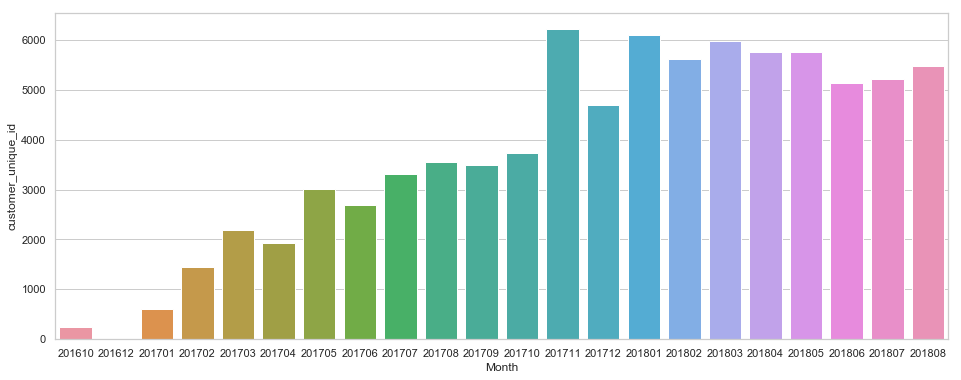

In [45]:
#creating a barplot for distribution 
sns.set(style="whitegrid")
plt.figure(figsize = (16,6))
sns.barplot(x="Month", y="customer_unique_id", data=active)

Monthly unique/new customers have increased from November 2017. We do not know whether there were any promotions or any sales/marketing efforts that aided this growth

In [46]:
#Analyzing new vs existing customers 
#create a dataframe containning unqiue customer id and the first_order_date 
first_purchase = merged.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
first_purchase.columns = ['customer_unique_id','firstpurchasedate']
first_purchase['First_Month'] = first_purchase['firstpurchasedate'].map(lambda date: 100*date.year + date.month)



In [47]:
#merge first purchase date column to our main dataframe 
merged = pd.merge(merged, first_purchase, on='customer_unique_id')

merged.head(2)

,index,order_id,order_item_id,product_category_name_english,customer_id,order_purchase_timestamp,customer_unique_id,Revenue,Month,order_item,firstpurchasedate,First_Month
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,cool_stuff,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,72.19,201709,100010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,201709
1,3,00024acbcdf0a6daa1e931b038114c75,1,perfumery,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,25.78,201808,100024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,201808


In [48]:
#assigning new and existing user values 
merged['user_type'] = 'New'
merged.loc[merged['Month']>merged['First_Month'],'user_type'] = 'Existing'

In [49]:
#creting dataframe for user type revenue 
user_type_revenue = merged.groupby(['Month','user_type'])['Revenue'].sum().reset_index()
x =user_type_revenue.query("Month !=201610 and Month != 201612")

In [50]:
#plot the distribution of revenue with respect to usertype 
scatter_data = [
    go.Scatter(
        x= x.loc[x['user_type'] == 'Existing']['Month'],
        y= x.loc[x['user_type'] == 'Existing']['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x= x.loc[x['user_type'] == 'New']['Month'],
        y= x.loc[x['user_type'] == 'New']['Revenue'],
        name = 'New'
    )
]

scatter_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=scatter_data, layout=scatter_layout)
pyoff.iplot(fig)

new customers revenue contribution had a consistent growth while the revenue contribution from existing customers was negligible. 

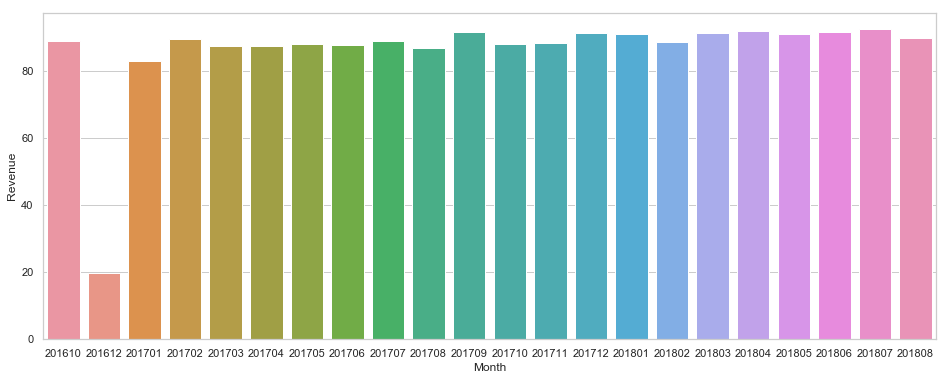

In [51]:
#monthly Avg_revenue per order 
order_avg = merged.groupby('Month')['Revenue'].mean().reset_index()

#creating a barplot for distribution 
sns.set(style="whitegrid")
plt.figure(figsize = (16,6))
sns.barplot(x="Month", y="Revenue", data=order_avg)

Monthly average order size is consistent 

In [52]:
#creating new column for recency 
merged['Recency'] = (merged['order_purchase_timestamp'].max() - merged['order_purchase_timestamp']).dt.days

In [53]:
#Analyzing recency
merged['Recency'].describe()

count    95969.000000
mean       239.549875
std        152.738176
min          0.000000
25%        116.000000
50%        220.000000
75%        349.000000
max        695.000000
Name: Recency, dtype: float64

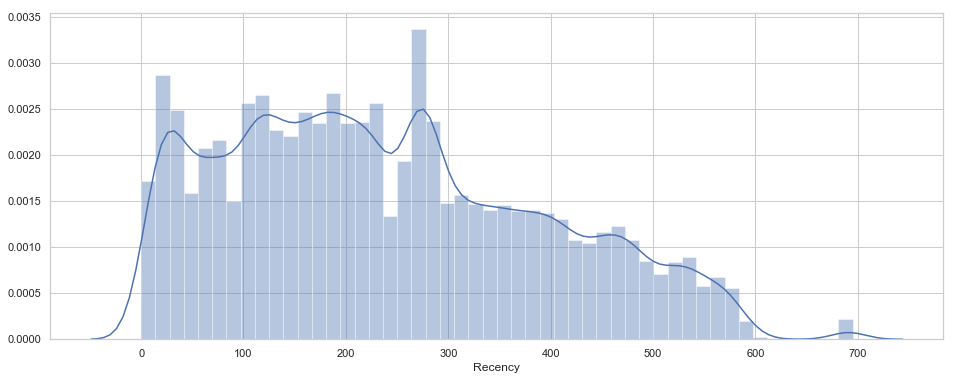

In [54]:
#recency distribution 
sns.set(style="whitegrid")
plt.figure(figsize = (16,6))
sns.distplot(merged['Recency'])


### ----5  Creating a baseline model ----

In [55]:
merged.head(2)

,index,order_id,order_item_id,product_category_name_english,customer_id,order_purchase_timestamp,customer_unique_id,Revenue,Month,order_item,firstpurchasedate,First_Month,user_type,Recency
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,cool_stuff,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,72.19,201709,100010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,201709,New,350
1,3,00024acbcdf0a6daa1e931b038114c75,1,perfumery,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,25.78,201808,100024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,201808,New,21


In [56]:
#Removing few features
tree = merged.drop(['order_item','index','order_id','order_item_id','customer_id','order_purchase_timestamp','customer_unique_id','Month','First_Month','firstpurchasedate'],axis = 1)

In [57]:
#converting all categorical features into numeric
tree = pd.get_dummies(tree,drop_first = True)

In [58]:
# Split Train/Test Set
Tree_train, Tree_test, rev_train, rev_test = train_test_split(tree.drop(["Revenue"], axis=1), tree["Revenue"],random_state=10, test_size=0.25)

In [59]:
# Examine shape of the dataset
Tree_train.shape

(71976, 73)

In [60]:
rev_train.head()

48173     86.40
12479     46.75
56644    116.94
70179     25.75
67632     64.03
Name: Revenue, dtype: float64

In [61]:
#fitting a decision tree model
tree_reg = DecisionTreeRegressor(criterion = 'mse' , max_depth=2)
tree_reg.fit(Tree_train,rev_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [62]:
#Compute errors on train model
r1 = rev_train - tree_reg.predict(Tree_train)

In [63]:
#creating a second tree 
# Fit second model
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(Tree_train,r1)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [64]:
#Compute errors on train model
r2 = r1 - tree_reg2.predict(Tree_train)

In [65]:
# Add up the predictions of each tree model, which is our ensemble of two trees
y_pred = sum(tree.predict(Tree_train) for tree in (tree_reg, tree_reg2))

In [66]:
#creating empty dataframe
pred  = pd.DataFrame()

In [67]:
pred['Actual'] = rev_train[0:20]

In [68]:
# Create dataframe of all predictions
pred['model_1'] = tree_reg.predict(Tree_train)[0:20]
pred['model_2'] = tree_reg2.predict(Tree_train)[0:20]
pred['Ensemble'] =y_pred[0:20]

# Display predictions
pred

,Actual,model_1,model_2,Ensemble
48173,86.40,92.874433,-1.557954,91.316478
12479,46.75,92.874433,-1.557954,91.316478
56644,116.94,92.874433,-1.557954,91.316478
70179,25.75,92.874433,-1.557954,91.316478
67632,64.03,92.874433,-1.557954,91.316478
62565,153.80,92.874433,-1.557954,91.316478
23663,127.54,92.874433,-1.557954,91.316478
61426,72.43,92.874433,-1.557954,91.316478
39918,78.65,92.874433,-1.557954,91.316478
74710,69.33,92.874433,-1.557954,91.316478


In [69]:
#creating a dataframe to observe the error for various tree's
errors = []
for n_estimators in [1,2,3,4,5,6,7,8,9,10]:
    clf = xgb.XGBRegressor(max_depth=2, n_estimators=n_estimators)
    clf.fit(Tree_train, rev_train, verbose=False)
    errors.append(
        {
            'Tree Count': n_estimators,
            'Average Error': np.average(rev_train - clf.predict(Tree_train)),
        })
    
n_estimators_lr = pd.DataFrame(errors).set_index('Tree Count').sort_index()
n_estimators_lr

,Average Error
Tree Count,
1,62.747418
2,43.924619
3,30.748293
4,21.524089
5,15.067433
6,10.547623
7,7.383321
8,5.168529
9,3.618196


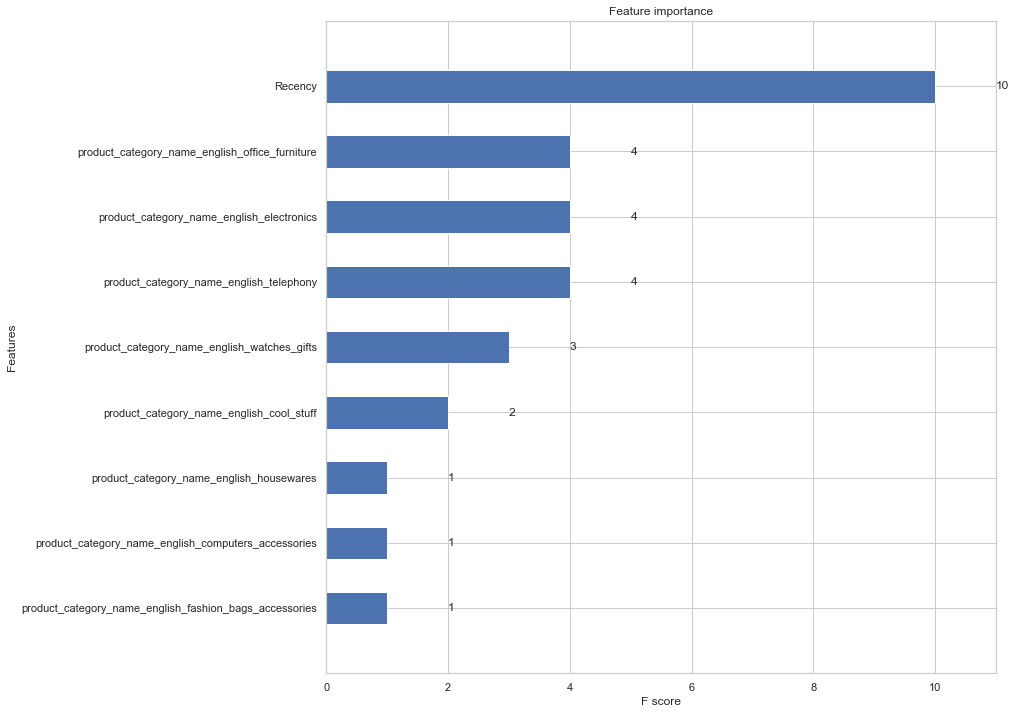

In [70]:
# Plot basic feature importance chart
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(clf, height=0.5, ax=ax)
plt.show()

Clearly as the number of trees increased the average error value decreased 

 ### ----6  Feature Engineering ----

In [71]:
#based on the above feature importance chart creating a subset for grouping product_categories
category_cluster = merged[['order_item','product_category_name_english','Revenue']]

In [72]:
#setting order_item as index 
category_cluster = category_cluster.set_index('order_item') 

In [73]:
#converting categories into numeric features 
category_dummied = pd.get_dummies(category_cluster,drop_first = True)

In [74]:
#using kmode algorithm to create clusters with respect to revenue 
cost = []
for num_clusters in list(range(1,7)):
    kmode = kmodes.KModes(n_clusters=num_clusters, init = "Huang", n_init = 1, verbose=1)
    kmode.fit_predict(category_dummied)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 190034.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 183098.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 18, cost: 184642.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25, cost: 172559.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 154, cost: 184397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 139, cost: 167195.0


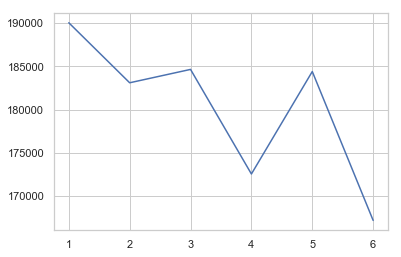

In [75]:
#plotting the cost curve to select k value 
y = np.array([i for i in range(1,7,1)])
plt.plot(y,cost)

for k=4 the cost function has reduced 

In [77]:
#creating the cluster model and adding column to the dataframe 
km = kmodes.KModes(n_clusters= 4, init='Huang', n_init=1, verbose=1)
clusters = km.fit_predict(category_dummied)
category_dummied['category_cluster'] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 188935.0


In [78]:
#filtering dataframe 
category_dummied = category_dummied[['category_cluster']]

In [79]:
category_dummied = category_dummied.reset_index()

In [80]:
#adding category_cluster to original dataframe

merged = merged.merge(category_dummied,on ='order_item',how = 'left')

In [82]:
merged.head()

,index,order_id,order_item_id,product_category_name_english,customer_id,order_purchase_timestamp,customer_unique_id,Revenue,Month,order_item,firstpurchasedate,First_Month,user_type,Recency,category_cluster
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,cool_stuff,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,72.19,201709,100010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,201709,New,350,0
1,3,00024acbcdf0a6daa1e931b038114c75,1,perfumery,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,25.78,201808,100024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,201808,New,21,0
2,5,00048cc3ae777c65dbb7d2a0634bc1ea,1,housewares,816cbea969fe5b689b39cfc97a506742,2017-05-15 21:42:34,85c835d128beae5b4ce8602c491bf385,34.59,201705,100048cc3ae777c65dbb7d2a0634bc1ea,2017-05-15 21:42:34,201705,New,470,0
3,6,00054e8431b9d7675808bcb819fb4a32,1,telephony,32e2e6ab09e778d99bf2e0ecd4898718,2017-12-10 11:53:48,635d9ac1680f03288e72ada3a1035803,31.75,201712,100054e8431b9d7675808bcb819fb4a32,2017-12-10 11:53:48,201712,New,262,0
4,8,0005a1a1728c9d785b8e2b08b904576c,1,health_beauty,16150771dfd4776261284213b89c304e,2018-03-19 18:40:33,639d23421f5517f69d0c3d6e6564cf0e,157.60,201803,10005a1a1728c9d785b8e2b08b904576c,2018-03-19 18:40:33,201803,New,162,0


In [84]:
final = merged.drop(['index','order_id','order_item_id','product_category_name_english','customer_id','order_purchase_timestamp','customer_unique_id','firstpurchasedate','Month','First_Month'],axis = 1)

In [85]:
final = final.set_index('order_item')

In [86]:
final = pd.get_dummies(final,drop_first = True)

,Revenue,Recency,category_cluster,user_type_New
Revenue,1.000000,-0.025777,0.044342,0.012020
Recency,-0.025777,1.000000,0.025543,0.049280
category_cluster,0.044342,0.025543,1.000000,0.002556
user_type_New,0.012020,0.049280,0.002556,1.000000


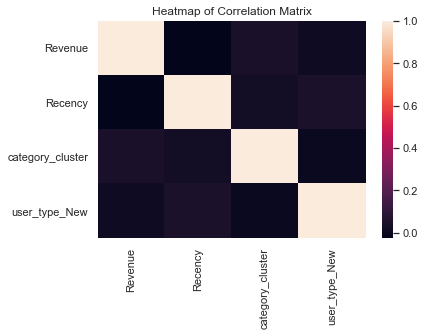

In [87]:
#correlation plot

corr = final.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

Clearly there is no strong correlation amongst features

### ----7  Creating model ----

In [89]:
#selecting columns 
merged_features = final.drop(['Revenue'],axis = 1)
Revenue = final.Revenue

In [90]:
# Split Train/Test Set
merged_features_train, merged_features_test, Revenue_train, Revenue_test = train_test_split(merged_features, Revenue, test_size=0.25)

In [91]:
#checking the sizes
print(merged_features_train.shape)
print(merged_features_test.shape)
print(Revenue_train.shape)
print(Revenue_test.shape)

(71976, 3)
(23993, 3)
(71976,)
(23993,)


In [92]:
#selecting model 
model = xgb.XGBRegressor()

In [93]:
# Define Parameters
param_grid = {"max_depth": [2,3,5],
              "max_features" : [1.0,0.3,0.1],
              "min_samples_leaf" : [3,5,9],
              "n_estimators": [50,100,150],
              "learning_rate": [0.05,0.1,0.2]}

In [94]:
# Perform Grid Search CV
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 ).fit(merged_features_train, Revenue_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

In [95]:
# Best hyperparmeter setting
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=2, max_features=1.0,
       min_child_weight=1, min_samples_leaf=3, missing=nan,
       monotone_constraints=None, n_estimators=150, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [96]:
#creating an evaluation set 
validation_set = [(merged_features_train,Revenue_train), ( merged_features_test, Revenue_test)]

### ----8  Best model ----

In [98]:
# Use our best model parameters found by GridSearchCV
best_model = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=2, max_features=1.0,
       min_child_weight=1, min_samples_leaf=3, missing=None,
       monotone_constraints=None, n_estimators=150, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [99]:
# Fit our model to the training set
best_model.fit(merged_features_train,Revenue_train, eval_set= validation_set, verbose=False)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=2, max_features=1.0,
       min_child_weight=1, min_samples_leaf=3, missing=nan,
       monotone_constraints=None, n_estimators=150, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

### ----9  Testing model ----

In [100]:
# Make predictions with test data
Revenue_pred = best_model.predict(merged_features_test)
predictions = [round(value) for value in Revenue_pred]


In [101]:
Revenue_test = Revenue_test.reset_index()
actual = Revenue_test['Revenue']

In [102]:
# Retrieve performance metrics
results = best_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)


Text(0.5, 1.0, 'XGBoost RMSE')

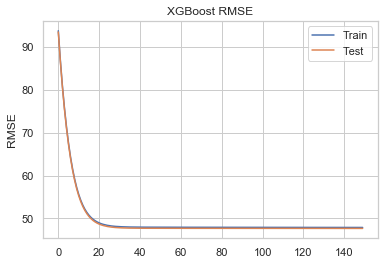

In [103]:
# Plot log loss curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

the logloss curve doesn't show overfitting

In [108]:
#mean sqaured error and Revenue totals 
mse = metrics.mean_squared_error(actual, predictions)
print('mse:',mse)
print('Actual_Revenue:',actual.sum())
print('Predicted_Revenue:',sum(predictions))

mse: 2272.433293252199
Actual_Revenue: 2154026.66
Predicted_Revenue: 2157547.0


### ----10  Summary ----

We can apply this model to future ecommerce metrics and obtain revenue at the transaction level and convert it into customer lifetimevalue. 

As the number of existing customers were less, I haven't included any frequency feature to cluster audience segments.

Improvement:

This model can be improved by adding new features. 

The geographical locations of customers and sellers can determine why customers in few areas are purchasing more compared to the others. 

